In [2]:
"""
For the subspace analysis, we have three methods. PCA, cvPCA, and cross-covariance analysis.

Each require the following:
# A recipe to get train and test data
# A recipe to get train place fields
# A way to fit the components
# And a way to measure the variance in the test data

So using a similar structure to the ABC RegressionModel, I can probably define a core structure as follows:

class SubspaceAnalysis:
    def fit(self, session, spks_type): ... # Returns the fit components and extras (data, placefields, etc)
    def score(self, session, fits, spks_type): ... # Returns the variance in the test data
    def reconstruction_score(self, session, fits, spks_type): ... # Returns the frobenius norm of the difference between the test data and the reconstructed data for each expanding subspace
    def get_scores(): ... # A similar cache method for getting scores without dealing with refitting which is slow

Note that I'll also need hyperparameters for measuring the placefields.... unfortunately this isn't just a user choice
because I should probably pick hyperparameters to maximize the variance the placefields explain in temporal data. 

But fortunately with some clever design I can build a structure that will 
allow me to make it easy to add or extend any one of the subspace methods. 
"""
print('bad docstring!')

bad docstring!


In [3]:
%reload_ext autoreload
%autoreload 2
# %matplotlib qt
%matplotlib inline

import random
import numpy as np
import torch
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from syd import make_viewer, Viewer
from tqdm import tqdm

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, format_spines, beeswarm, errorPlot, save_figure
from vrAnalysis.processors.placefields import get_placefield
from dimilibi import PCA, SVCA
from dimensionality_manuscript.registry import PopulationRegistry, get_subspace, SubspaceName
from dimensionality_manuscript.subspace_analysis.base import Subspace
from dimensionality_manuscript.regression_models.hyperparameters import PlaceFieldHyperparameters
from dimensionality_manuscript.simulations import sqrtm_spd


plt.rcParams["font.size"] = 14

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
SUBSPACE_NAMES: list[SubspaceName] = [
    "pca_subspace",
    # "cvpca_subspace",
    # "svca_subspace",
    "covcov_subspace",
    "covcov_crossvalidated_subspace"
]
subspaces = [get_subspace(name, registry) for name in SUBSPACE_NAMES]
spks_type = "oasis"
sessiondb = get_database("vrSessions")
registry = PopulationRegistry()

specific_hyperparameters = PlaceFieldHyperparameters(num_bins=100, smooth_width=None)

num_sessions = len(sessiondb.iter_sessions(imaging=True))
mouse_names = []
model_metrics = [[] for _ in subspaces]
for isession, session in enumerate(tqdm(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))):
    mouse_names.append(session.mouse_name)
    for imodel, model in enumerate(subspaces):        
        metrics = model.get_score(session, spks_type=spks_type, hyperparameters=specific_hyperparameters)
        model_metrics[imodel].append(metrics)
mouse_names = np.array(mouse_names)

score = np.full((len(subspaces), len(mouse_names)), np.nan)
varact, varpos = [], []
for i in range(len(subspaces)):
    c_scores = np.array([m["evaluation_score"] for m in model_metrics[i]])
    c_varact = [m["variance_activity"] for m in model_metrics[i]]
    c_varpos = [m["variance_placefields"] for m in model_metrics[i]]
    score[i] = c_scores
    varact.append(c_varact)
    varpos.append(c_varpos)

num_envs = 3
max_dims = max([len(v) for v in varact[0]+varact[1]])
varact_pad = np.full((len(subspaces), num_envs, len(mouse_names), max_dims), np.nan)
varpos_pad = np.full((len(subspaces), num_envs, len(mouse_names), max_dims), np.nan)
for i in range(len(subspaces)):
    for j in range(len(mouse_names)):
        num_dims = len(varact[i][j])
        idx_env = int(num_dims // 100) - 1
        varact_pad[i, idx_env, j, :len(varact[i][j])] = varact[i][j]
        varpos_pad[i, idx_env, j, :len(varpos[i][j])] = varpos[i][j]

mice = list(set(mouse_names))
avg_scores = np.full((len(SUBSPACE_NAMES), len(mice)), np.nan)
avg_varact = np.full((len(SUBSPACE_NAMES), num_envs, len(mice), max_dims), np.nan)
avg_varpos = np.full((len(SUBSPACE_NAMES), num_envs, len(mice), max_dims), np.nan)
for imodel, model_name in enumerate(SUBSPACE_NAMES):
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse} with model {model_name}")
        avg_scores[imodel, imouse] = np.mean(score[imodel][mouse_names == mouse])
        avg_varact[imodel, :, imouse] = np.nanmean(varact_pad[imodel][:, mouse_names == mouse], axis=1)
        avg_varpos[imodel, :, imouse] = np.nanmean(varpos_pad[imodel][:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:00<00:00, 1663.63it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\1309661552.py:55: RuntimeWarning: Mean of empty slice
  avg_varact[imodel, :, imouse] = np.nanmean(varact_pad[imodel][:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\1309661552.py:56: RuntimeWarning: Mean of empty slice
  avg_varpos[imodel, :, imouse] = np.nanmean(varpos_pad[imodel][:, mouse_names == mouse], axis=1)


In [6]:
idxmodel0 = 1
idxmodel1 = 2

class SubspaceViewer(Viewer):
    def __init__(self):
        self.add_integer("idx_mouse", min=0, max=len(mice)-1)
        self.add_integer("num_envs", min=1, max=num_envs)
        self.add_selection("plot_type", options=["both", "difference"])
        self.add_selection("data_type", options=["cumvariance", "variance"])
        self.add_selection("xscale", options=["linear", "log"])
        self.add_selection("yscale", options=["linear", "log"])
        self.add_boolean("normalize", value=True)
        self.add_boolean("all", value=True)

    def plot(self, state):
        idx_env = state["num_envs"] - 1
        if state["all"]:
            data_activity = avg_varact[:, idx_env]
            data_placefields = avg_varpos[:, idx_env]
            if state["normalize"]:
                total_variance = np.nansum(data_activity, axis=2, keepdims=True)
                data_activity = data_activity / total_variance
                data_placefields = data_placefields / total_variance
            if state["data_type"] == "cumvariance":
                data_activity = np.cumsum(data_activity, axis=2)
                data_placefields = np.cumsum(data_placefields, axis=2)
                
        else:
            idx_mouse = state["idx_mouse"]
            data_activity = avg_varact[:, idx_env, idx_mouse]
            data_placefields = avg_varpos[:, idx_env, idx_mouse]
            if state["normalize"]:
                total_variance = np.nansum(data_activity, axis=1, keepdims=True)
                data_activity = data_activity / total_variance
                data_placefields = data_placefields / total_variance

            if state["data_type"] == "cumvariance":
                data_activity = np.cumsum(data_activity, axis=1)
                data_placefields = np.cumsum(data_placefields, axis=1)

        fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
        if state["all"]:
            if state["plot_type"] == "difference":
                difference = data_activity - data_placefields
                ax[0].plot(range(1, max_dims+1), difference[idxmodel0].T, color="k", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), difference[idxmodel1].T, color="k", alpha=0.25)
                ax[0].plot(range(1, max_dims+1), np.nanmean(difference[idxmodel0], axis=0), color="k")
                ax[1].plot(range(1, max_dims+1), np.nanmean(difference[idxmodel1], axis=0), color="k")
            elif state["plot_type"] == "both":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0].T, color="k", alpha=0.25)
                ax[0].plot(range(1, max_dims+1), data_placefields[idxmodel0].T, color="b", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1].T, color="k", alpha=0.25)
                ax[1].plot(range(1, max_dims+1), data_placefields[idxmodel1].T, color="b", alpha=0.25)

                ax[0].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel0], axis=0), color="k")
                ax[0].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel0], axis=0), color="b")
                ax[1].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel1], axis=0), color="k")
                ax[1].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel1], axis=0), color="b")

                ax[0].set_title(f"{np.nansum(data_activity[idxmodel0])}")
                ax[1].set_title(f"{np.nansum(data_activity[idxmodel1])}")
        else:
            if state["plot_type"] == "difference":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0] - data_placefields[idxmodel0], color="k")
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1] - data_placefields[idxmodel1], color="k")
            elif state["plot_type"] == "both":
                ax[0].plot(range(1, max_dims+1), data_activity[idxmodel0], color="k")
                ax[0].plot(range(1, max_dims+1), data_placefields[idxmodel0], color="b")
                ax[1].plot(range(1, max_dims+1), data_activity[idxmodel1], color="k")
                ax[1].plot(range(1, max_dims+1), data_placefields[idxmodel1], color="b")
                ax[0].set_title(f"{np.nansum(data_activity[idxmodel0])}")
                ax[1].set_title(f"{np.nansum(data_activity[idxmodel1])}")
        ax[0].set_xscale(state["xscale"])
        ax[1].set_xscale(state["xscale"])
        ax[0].set_yscale(state["yscale"])
        ax[1].set_yscale(state["yscale"])
        return fig

viewer = SubspaceViewer()
viewer.show()

C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\3536857975.py:55: RuntimeWarning: Mean of empty slice
  ax[0].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel0], axis=0), color="k")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\3536857975.py:56: RuntimeWarning: Mean of empty slice
  ax[0].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel0], axis=0), color="b")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\3536857975.py:57: RuntimeWarning: Mean of empty slice
  ax[1].plot(range(1, max_dims+1), np.nanmean(data_activity[idxmodel1], axis=0), color="k")
C:\Users\Andrew\AppData\Local\Temp\ipykernel_13108\3536857975.py:58: RuntimeWarning: Mean of empty slice
  ax[1].plot(range(1, max_dims+1), np.nanmean(data_placefields[idxmodel1], axis=0), color="b")


C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\helpers\plotting.py:80: RuntimeWarning: Mean of empty slice
  meanData = mean(data, axis=axis)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.3721235887326326
0.4607942654312449
0.4685327144612684


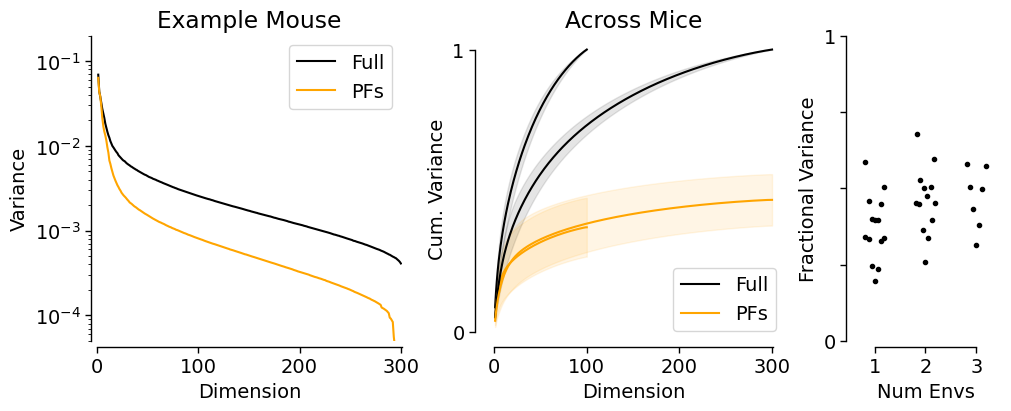

In [22]:
total_variance = np.nansum(avg_varact, axis=3, keepdims=True)
norm_data_activity = avg_varact / total_variance
norm_data_placefields = avg_varpos / total_variance

csnorm_data_activity = np.cumsum(norm_data_activity, axis=3)
csnorm_data_placefields = np.cumsum(norm_data_placefields, axis=3)


idx_model = 2 # Use the COVCOV model
idx_mouse = 6
beewidth = 0.2
full_color = "black"
placefield_color = "orange"
        
xlim = (0, max_dims+1)
ylim = (5e-5, 2e-1)
xticks = [0, 100, 200, 300]

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(10, 4), width_ratios=[2, 2, 1], layout="constrained")
need_label = True
for inumenv in [2]:
    if np.any(np.isnan(norm_data_activity[idx_model, inumenv, idx_mouse])):
        print(f"NaN values in norm_data_activity for model {idx_model}, env {inumenv}, mouse {idx_mouse}")
    if np.any(np.isnan(norm_data_placefields[idx_model, inumenv, idx_mouse])):
        print(f"NaN values in norm_data_placefields for model {idx_model}, env {inumenv}, mouse {idx_mouse}")
    ax[0].plot(range(1, max_dims+1), norm_data_activity[idx_model, inumenv, idx_mouse].T, color=full_color, label="Full" if need_label else None)
    ax[0].plot(range(1, max_dims+1), norm_data_placefields[idx_model, inumenv, idx_mouse].T, color=placefield_color, label="PFs" if need_label else None)
    need_label = False
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("Variance")
ax[0].legend(loc="upper right")
ax[0].set_title("Example Mouse")
ax[0].set_yscale('log')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
format_spines(ax[0], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim)


ylim = (0, 1)
need_label = True
for inumenv in [0, 2]:
    errorPlot(range(1, max_dims+1), csnorm_data_activity[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=full_color, label="Full" if need_label else None, alpha=0.1)
    errorPlot(range(1, max_dims+1), csnorm_data_placefields[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=placefield_color, label="PFs" if need_label else None, alpha=0.1)
    need_label = False
ax[1].set_xlabel("Dimension")
ax[1].set_ylabel("Cum. Variance")
ax[1].legend(loc="lower right")
ax[1].set_title("Across Mice")
format_spines(ax[1], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim, yticks=ylim)

show_envs = [0, 1, 2]
xbounds = (0, len(show_envs)-1)
xlim = (-0.5, len(show_envs)-0.5)
ylim = (0, 1)
for ii, idx in enumerate(show_envs):
    ilast = (idx + 1) * 100 - 1
    c_data_activity = csnorm_data_activity[idx_model, idx, :, ilast - 1]
    c_data_placefields = csnorm_data_placefields[idx_model, idx, :, ilast - 1]
    c_fraction = c_data_placefields / c_data_activity
    c_valid_fraction = c_fraction[~np.isnan(c_fraction)]
    print(np.mean(c_valid_fraction))
    ax[2].plot(ii + beewidth*beeswarm(c_valid_fraction), c_valid_fraction, color=full_color, marker=".", linestyle="none", label="Full")
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_xlabel("Num Envs")
ax[2].set_ylabel("Fractional Variance")
format_spines(ax[2], x_pos=-0.02, y_pos=-0.02, xbounds=xbounds, ybounds=ylim)
ax[2].set_xticks(range(len(show_envs)))
ax[2].set_xticklabels([f"{idx + 1}" for idx in show_envs])
ax[2].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[2].set_yticklabels([0, '', '', '', 1])

model_name = {
    0: "pca",
    1: "covcov",
    2: "covcov_correlation",
}
figure_path = registry.registry_paths.figure_path / "subspace_analysis" / f"{model_name[idx_model]}_subspace_basic_figure"
# save_figure(fig, figure_path)

plt.show()

C:\Users\Andrew\Documents\GitHub\vrAnalysis\vrAnalysis\helpers\plotting.py:80: RuntimeWarning: Mean of empty slice
  meanData = mean(data, axis=axis)
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


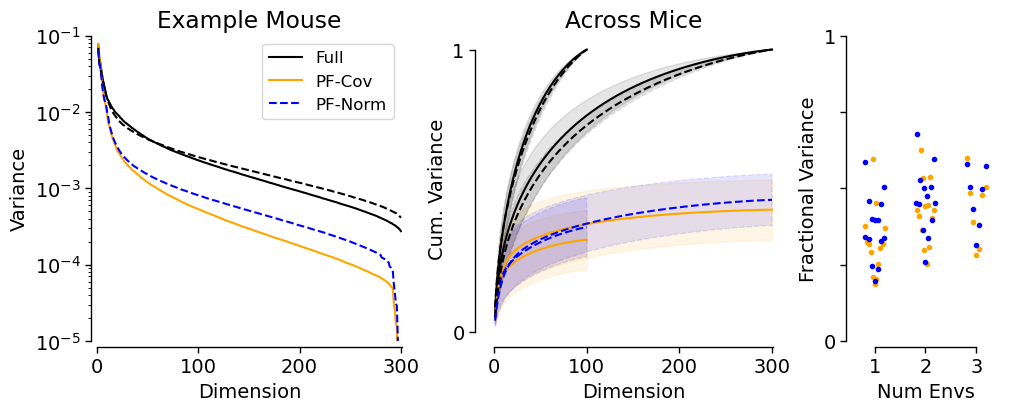

In [35]:
total_variance = np.nansum(avg_varact, axis=3, keepdims=True)
norm_data_activity = avg_varact / total_variance
norm_data_placefields = avg_varpos / total_variance

csnorm_data_activity = np.cumsum(norm_data_activity, axis=3)
csnorm_data_placefields = np.cumsum(norm_data_placefields, axis=3)


idx_model_0 = 1
idx_model_1 = 2
reference_color = "black"
color_model = ["orange", "blue"]
linestyle_model = ["solid", "dashed"]
model_label = ["PF-Cov", "PF-Norm"]
idx_mouse = 6
beewidth = 0.2
        
xlim = (0, max_dims+1)
ylim = (1e-5, 1e-1)
xticks = [0, 100, 200, 300]

plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(10, 4), width_ratios=[2, 2, 1], layout="constrained")
for imodel, idx_model in enumerate([idx_model_0, idx_model_1]):
    full_label = "Full" if imodel == 0 else None
    pf_label = model_label[imodel]
    for inumenv in [2]:
        if np.any(np.isnan(norm_data_activity[idx_model, inumenv, idx_mouse])):
            print(f"NaN values in norm_data_activity for model {idx_model}, env {inumenv}, mouse {idx_mouse}")
        if np.any(np.isnan(norm_data_placefields[idx_model, inumenv, idx_mouse])):
            print(f"NaN values in norm_data_placefields for model {idx_model}, env {inumenv}, mouse {idx_mouse}")
        ax[0].plot(range(1, max_dims+1), norm_data_activity[idx_model, inumenv, idx_mouse].T, color=reference_color, linestyle=linestyle_model[imodel], label=full_label)
        ax[0].plot(range(1, max_dims+1), norm_data_placefields[idx_model, inumenv, idx_mouse].T, color=color_model[imodel], linestyle=linestyle_model[imodel], label=pf_label)
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("Variance")
ax[0].legend(loc="upper right", fontsize=12)
ax[0].set_title("Example Mouse")
ax[0].set_yscale('log')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
format_spines(ax[0], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim)


ylim = (0, 1)
for imodel, idx_model in enumerate([idx_model_0, idx_model_1]):
    full_label = "Full" if imodel == 0 else None
    pf_label = model_label[imodel]
    for inumenv in [0, 2]:
        errorPlot(range(1, max_dims+1), csnorm_data_activity[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=reference_color, linestyle=linestyle_model[imodel], label=full_label, alpha=0.1)
        errorPlot(range(1, max_dims+1), csnorm_data_placefields[idx_model, inumenv], axis=0, ax=ax[1], se=False, color=color_model[imodel], linestyle=linestyle_model[imodel], label=pf_label, alpha=0.1)
ax[1].set_xlabel("Dimension")
ax[1].set_ylabel("Cum. Variance")
ax[1].set_title("Across Mice")
format_spines(ax[1], x_pos=-0.02, y_pos=-0.02, xbounds=xlim, xticks=xticks, ybounds=ylim, yticks=ylim)

show_envs = [0, 1, 2]
xbounds = (0, len(show_envs)-1)
xlim = (-0.5, len(show_envs)-0.5)
ylim = (0, 1)
for imodel, idx_model in enumerate([idx_model_0, idx_model_1]):
    color = color_model[imodel]
    for ii, idx in enumerate(show_envs):
        ilast = (idx + 1) * 100 - 1
        c_data_activity = csnorm_data_activity[idx_model, idx, :, ilast - 1]
        c_data_placefields = csnorm_data_placefields[idx_model, idx, :, ilast - 1]
        c_fraction = c_data_placefields / c_data_activity
        c_valid_fraction = c_fraction[~np.isnan(c_fraction)]
        ax[2].plot(ii + beewidth*beeswarm(c_valid_fraction), c_valid_fraction, color=color, marker=".", linestyle="none")
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_xlabel("Num Envs")
ax[2].set_ylabel("Fractional Variance")
format_spines(ax[2], x_pos=-0.02, y_pos=-0.02, xbounds=xbounds, ybounds=ylim)
ax[2].set_xticks(range(len(show_envs)))
ax[2].set_xticklabels([f"{idx + 1}" for idx in show_envs])
ax[2].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[2].set_yticklabels([0, '', '', '', 1])

# model_name = {
#     0: "pca",
#     1: "covcov",
#     2: "covcov_correlation",
# }
# figure_path = registry.registry_paths.figure_path / "subspace_analysis" / f"{model_name[idx_model]}_subspace_basic_figure"
# # save_figure(fig, figure_path)

plt.show()

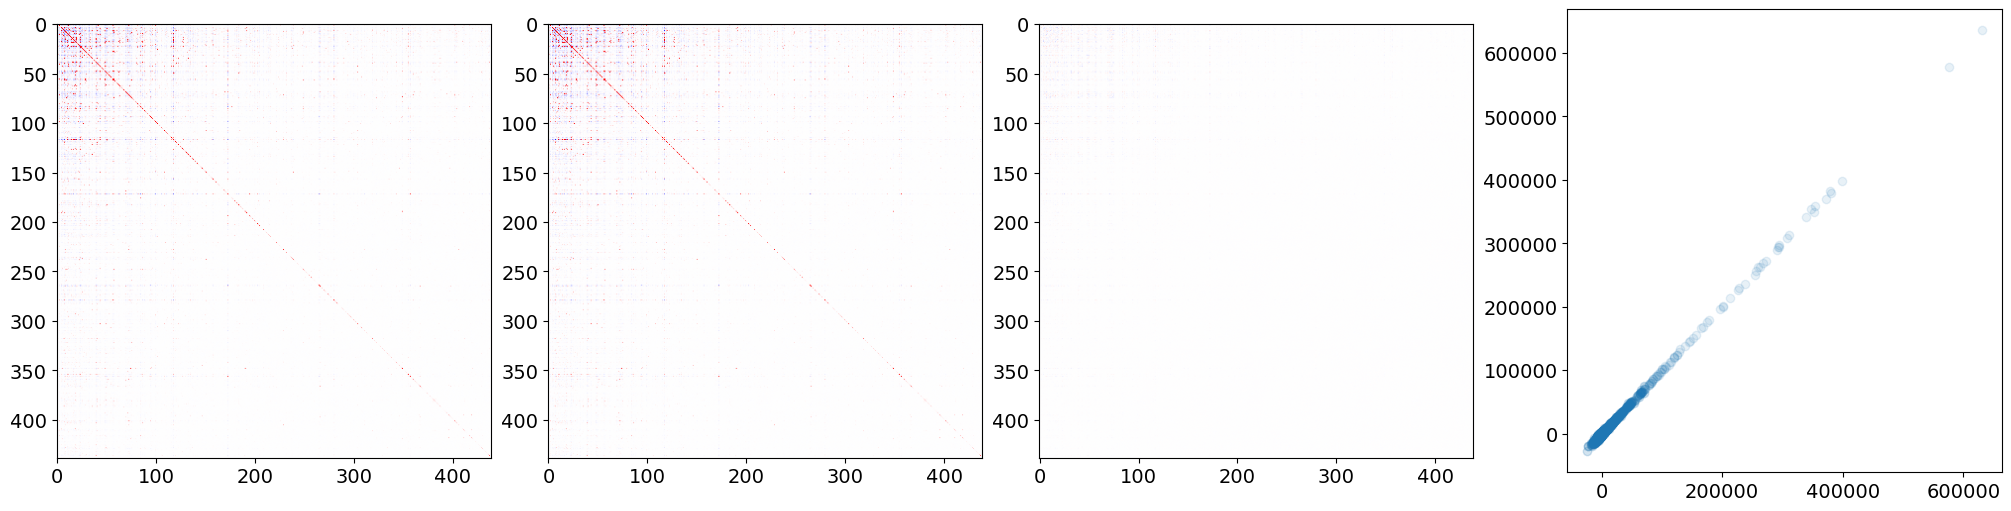

In [27]:
def gaussian_resample(data: torch.Tensor, num_samples: int | None = None):
    N = data.shape[0]
    num_samples = num_samples or data.shape[1]
    mu = torch.mean(data, dim=1, keepdim=True)
    cov = torch.cov(data)
    eval, evec = torch.linalg.eigh(cov)
    dev = evec @ torch.diag(torch.sqrt(torch.clamp_min(eval, 0.0))) @ torch.randn(N, num_samples)
    return dev + mu

session = sessiondb.iter_sessions(imaging=True)[0]

model = get_subspace("covcov_crossvalidated_subspace", registry)
hyperparameters = model.hyperparameters
nan_safe = False
spks_type = "oasis"
train_data, frame_behavior_train0, num_neurons = model.get_session_data(session, spks_type, "train", use_cell_split=False)
train_data = model._center_data(train_data, True)

n_keep = int(train_data.shape[1] * 0.3)
train_data = train_data[:n_keep]

cov1 = torch.cov(train_data)

resample1 = gaussian_resample(train_data, train_data.shape[1] * 20)
rscov1 = torch.cov(resample1)

max_val = np.max(np.abs(np.stack([cov1, rscov1, cov1 - rscov1]))) / 20

plt.close('all')
fig, ax = plt.subplots(1, 4, figsize=(20, 5), layout="constrained")
ax[0].imshow(cov1, cmap="bwr", vmin=-max_val, vmax=max_val)
ax[1].imshow(rscov1, cmap="bwr", vmin=-max_val, vmax=max_val)
ax[2].imshow(cov1 - rscov1, cmap="bwr", vmin=-max_val, vmax=max_val)
ax[3].scatter(cov1.flatten(), rscov1.flatten(), alpha=0.1)
plt.show()

In [40]:
session = sessiondb.iter_sessions(imaging=True)[0]

model = get_subspace("covcov_crossvalidated_subspace", registry)
hyperparameters = model.hyperparameters
nan_safe = False
spks_type = "oasis"

split0 = "train0"
split1 = "train1"
train0_data, frame_behavior_train0, num_neurons = model.get_session_data(session, spks_type, split0, use_cell_split=False)
train1_data, _, _ = model.get_session_data(session, spks_type, split1, use_cell_split=False)
train0_data = model._center_data(train0_data, model.centered)
train1_data = model._center_data(train1_data, model.centered)

# Generate gaussian resampled data
gauss0_data = gaussian_resample(train0_data)
gauss1_data = gaussian_resample(train1_data)

dist_edges = model._get_placefield_dist_edges(session, hyperparameters)
placefield0 = get_placefield(
    train0_data.T.numpy(),
    frame_behavior_train0,
    dist_edges=dist_edges,
    average=True,
    smooth_width=hyperparameters.smooth_width,
)
placefield0_extended = torch.tensor(placefield0.placefield).reshape(-1, num_neurons).T

pfgauss0 = get_placefield(
    gauss0_data.T.numpy(),
    frame_behavior_train0,
    dist_edges=dist_edges,
    average=True,
    smooth_width=hyperparameters.smooth_width,
)
pfgauss0_extended = torch.tensor(pfgauss0.placefield).reshape(-1, num_neurons).T

# Check for NaNs and filter if needed
placefield0_extended, train0_data = model._check_and_filter_nans(placefield0_extended, train0_data, nan_safe=nan_safe)

num_components = model._compute_num_components(model.max_components, train0_data.shape, train1_data.shape, placefield0_extended.shape)

# Get the root covariance matrices for activity in each split
if model.match_dimensions:
    pca_activity0 = PCA(num_components=num_components).fit(train0_data)
    pca_activity1 = PCA(num_components=num_components).fit(train1_data)
    pca_gauss0 = PCA(num_components=num_components).fit(gauss0_data)
    pca_gauss1 = PCA(num_components=num_components).fit(gauss1_data)
else:
    pca_activity0 = PCA().fit(train0_data)
    pca_activity1 = PCA().fit(train1_data)
    pca_gauss0 = PCA().fit(gauss0_data)
    pca_gauss1 = PCA().fit(gauss1_data)
components0 = pca_activity0.get_components()
components1 = pca_activity1.get_components()
eigenvalues0 = pca_activity0.get_eigenvalues()
eigenvalues1 = pca_activity1.get_eigenvalues()
root_cov_activity0 = components0 @ torch.diag(torch.sqrt(eigenvalues0)) @ components0.T
root_cov_activity1 = components1 @ torch.diag(torch.sqrt(eigenvalues1)) @ components1.T

# Gauss version
components_gauss0 = pca_gauss0.get_components()
components_gauss1 = pca_gauss1.get_components()
eigenvalues_gauss0 = pca_gauss0.get_eigenvalues()
eigenvalues_gauss1 = pca_gauss1.get_eigenvalues()
root_cov_gauss0 = components_gauss0 @ torch.diag(torch.sqrt(eigenvalues_gauss0)) @ components_gauss0.T
root_cov_gauss1 = components_gauss1 @ torch.diag(torch.sqrt(eigenvalues_gauss1)) @ components_gauss1.T

# Get the root covariance matrices for place fields in the first half split
pca_placefields0 = PCA(num_components=num_components).fit(placefield0_extended)
pf_components0 = pca_placefields0.get_components()
pf_eigenvalues0 = pca_placefields0.get_eigenvalues()
root_cov_placefields0 = pf_components0 @ torch.diag(torch.sqrt(pf_eigenvalues0)) @ pf_components0.T

# Gauss version
pca_pfgauss0 = PCA(num_components=num_components).fit(pfgauss0_extended)
pf_components_gauss0 = pca_pfgauss0.get_components()
pf_eigenvalues_gauss0 = pca_pfgauss0.get_eigenvalues()
root_cov_pfgauss0 = pf_components_gauss0 @ torch.diag(torch.sqrt(pf_eigenvalues_gauss0)) @ pf_components_gauss0.T

# Measure SVD on activity vs activity or PFs vs activity
SVCA_activity = SVCA(centered=False, num_components=num_components).fit(root_cov_activity0, root_cov_activity1)
SVCA_placefields = SVCA(centered=False, num_components=num_components).fit(root_cov_placefields0, root_cov_activity1)

SVCA_activity_gauss = SVCA(centered=False, num_components=num_components).fit(root_cov_gauss0, root_cov_gauss1)
SVCA_placefields_gauss = SVCA(centered=False, num_components=num_components).fit(root_cov_pfgauss0, root_cov_gauss1)

subspace = Subspace(
    subspace_activity=SVCA_activity,
    subspace_placefields=SVCA_placefields,
    extras=dict(placefield0=placefield0),
)

# Then test
split0 = "validation"
split1 = "test"
test0_data, frame_behavior_test0, num_neurons = model.get_session_data(session, spks_type, split0, use_cell_split=False)
test1_data, _, _ = model.get_session_data(session, spks_type, split1, use_cell_split=False)
test0_data = model._center_data(test0_data, model.centered)
test1_data = model._center_data(test1_data, model.centered)

# Gauss version
gauss0_test = gaussian_resample(test0_data)
gauss1_test = gaussian_resample(test1_data)

dist_edges = model._get_placefield_dist_edges(session, hyperparameters)
placefield0 = get_placefield(
    test0_data.T.numpy(),
    frame_behavior_test0,
    dist_edges=dist_edges,
    average=True,
    smooth_width=hyperparameters.smooth_width,
)
placefield0_extended = torch.tensor(placefield0.placefield).reshape(-1, num_neurons).T

pfgauss0 = get_placefield(
    gauss0_test.T.numpy(),
    frame_behavior_test0,
    dist_edges=dist_edges,
    average=True,
    smooth_width=hyperparameters.smooth_width,
)   
pfgauss0_extended = torch.tensor(pfgauss0.placefield).reshape(-1, num_neurons).T

# Check for NaNs and filter if needed
placefield0_extended, test0_data = model._check_and_filter_nans(placefield0_extended, test0_data, nan_safe=nan_safe)

num_components = model._compute_num_components(model.max_components, test0_data.shape, test1_data.shape, placefield0_extended.shape)

# Get the root covariance matrices for activity in each split
if model.match_dimensions:
    pca_activity0 = PCA(num_components=num_components).fit(test0_data)
    pca_activity1 = PCA(num_components=num_components).fit(test1_data)
    pca_gauss0 = PCA(num_components=num_components).fit(gauss0_test)
    pca_gauss1 = PCA(num_components=num_components).fit(gauss1_test)
else:
    pca_activity0 = PCA().fit(test0_data)
    pca_activity1 = PCA().fit(test1_data)
    pca_gauss0 = PCA().fit(gauss0_test)
    pca_gauss1 = PCA().fit(gauss1_test)
components0 = pca_activity0.get_components()
components1 = pca_activity1.get_components()
eigenvalues0 = pca_activity0.get_eigenvalues()
eigenvalues1 = pca_activity1.get_eigenvalues()
root_cov_activity0 = components0 @ torch.diag(torch.sqrt(eigenvalues0)) @ components0.T
root_cov_activity1 = components1 @ torch.diag(torch.sqrt(eigenvalues1)) @ components1.T

# Gauss version 
components_gauss0 = pca_gauss0.get_components() 
components_gauss1 = pca_gauss1.get_components()
eigenvalues_gauss0 = pca_gauss0.get_eigenvalues()
eigenvalues_gauss1 = pca_gauss1.get_eigenvalues()
root_cov_gauss0 = components_gauss0 @ torch.diag(torch.sqrt(eigenvalues_gauss0)) @ components_gauss0.T
root_cov_gauss1 = components_gauss1 @ torch.diag(torch.sqrt(eigenvalues_gauss1)) @ components_gauss1.T

# Get the root covariance matrices for place fields in the first half split
pca_placefields0 = PCA(num_components=num_components).fit(placefield0_extended)
pf_components0 = pca_placefields0.get_components()
pf_eigenvalues0 = pca_placefields0.get_eigenvalues()
root_cov_placefields0 = pf_components0 @ torch.diag(torch.sqrt(pf_eigenvalues0)) @ pf_components0.T

# Gauss version 
pca_pfgauss0 = PCA(num_components=num_components).fit(pfgauss0_extended)
pf_components_gauss0 = pca_pfgauss0.get_components()
pf_eigenvalues_gauss0 = pca_pfgauss0.get_eigenvalues()
root_cov_pfgauss0 = pf_components_gauss0 @ torch.diag(torch.sqrt(pf_eigenvalues_gauss0)) @ pf_components_gauss0.T

# variance activity
variance_activity = subspace.subspace_activity.score(root_cov_activity0, root_cov_activity1, normalize=False)[0]
variance_placefields = subspace.subspace_placefields.score(root_cov_placefields0, root_cov_activity1, normalize=False)[0]

# Gauss version
variance_activity_gauss = SVCA_activity_gauss.score(root_cov_gauss0, root_cov_gauss1, normalize=False)[0]
variance_placefields_gauss = SVCA_placefields_gauss.score(root_cov_pfgauss0, root_cov_gauss1, normalize=False)[0]

variance = dict(
    variance_activity=variance_activity,
    variance_placefields=variance_placefields,
    variance_activity_gauss=variance_activity_gauss,
    variance_placefields_gauss=variance_placefields_gauss,
)

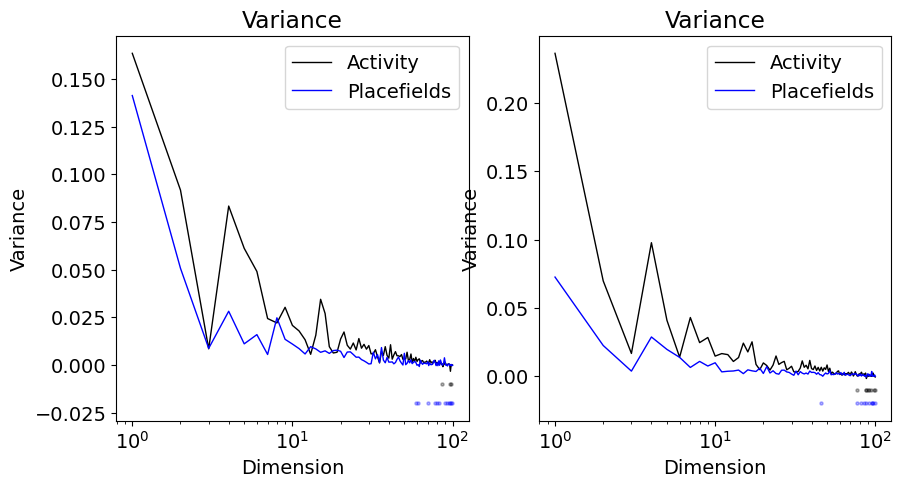

In [41]:
xscale = "log"
yscale = "linear"

num_dimensions = variance_activity.shape[0]
xvals = torch.arange(num_dimensions) + 1
negs_activity = torch.where(variance_activity < 0)[0]
negs_placefields = torch.where(variance_placefields < 0)[0]

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(xvals, variance_activity / torch.sum(variance_activity), color="k", linewidth=1.0)
ax[0].plot(xvals, variance_placefields / torch.sum(variance_activity), color="b", linewidth=1.0)
ax[0].scatter(negs_activity, -0.01 * torch.ones(negs_activity.shape[0]), c="k", s=5, alpha=0.3)
ax[0].scatter(negs_placefields, -0.02 * torch.ones(negs_placefields.shape[0]), c="b", s=5, alpha=0.3)
ax[0].set_xscale(xscale)
ax[0].set_yscale(yscale)
ax[0].set_xlabel("Dimension")
ax[0].set_ylabel("Variance")
ax[0].legend(["Activity", "Placefields"])
ax[0].set_title("Variance")

negs_activity_gauss = torch.where(variance_activity_gauss < 0)[0]
negs_placefields_gauss = torch.where(variance_placefields_gauss < 0)[0]

ax[1].plot(xvals, variance_activity_gauss / torch.sum(variance_activity_gauss), color="k", linewidth=1.0)
ax[1].plot(xvals, variance_placefields_gauss / torch.sum(variance_activity_gauss), color="b", linewidth=1.0)
ax[1].scatter(negs_activity_gauss, -0.01 * torch.ones(negs_activity_gauss.shape[0]), c="k", s=5, alpha=0.3)
ax[1].scatter(negs_placefields_gauss, -0.02 * torch.ones(negs_placefields_gauss.shape[0]), c="b", s=5, alpha=0.3)
ax[1].set_xscale(xscale)
ax[1].set_yscale(yscale)
ax[1].set_xlabel("Dimension")
ax[1].set_ylabel("Variance")
ax[1].legend(["Activity", "Placefields"])
ax[1].set_title("Variance")
plt.show()

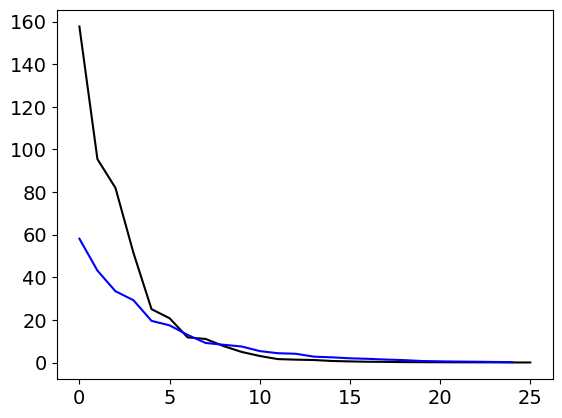

In [ ]:
# This block runs a simulation to check if interleaved cross-covcov method is same as block version
num_samples = 100000
num_neurons = 100
num_components = 100
num_source = 50

# Generate eigenspectrum
eigenvalues = 1.2 ** -torch.arange(num_components)
same_fraction = 0.9
_ev_shared = torch.randn(num_neurons, num_neurons)
eigenvectors_train = torch.linalg.qr(same_fraction * _ev_shared + (1-same_fraction) * torch.randn(num_neurons, num_neurons)).Q[:, :num_components]
eigenvectors_test = torch.linalg.qr(same_fraction * _ev_shared + (1-same_fraction) * torch.randn(num_neurons, num_neurons)).Q[:, :num_components]

# Generate random data
train_data = eigenvectors_train @ torch.diag(torch.sqrt(eigenvalues)) @ torch.randn(num_components, num_samples)
test_data = eigenvectors_test @ torch.diag(torch.sqrt(eigenvalues)) @ torch.randn(num_components, num_samples)

train_source = train_data[:num_source]
train_target = train_data[num_source:]
test_source = test_data[:num_source]
test_target = test_data[num_source:]

test_crcov = test_source @ test_target.T

# Train PCAs
pca_source = PCA().fit(train_source)
pca_target = PCA().fit(train_target)

# Interleaved cross-covcov metric
train_source_evecs = pca_source.get_components()
train_source_eval = torch.diag(torch.sqrt(pca_source.get_eigenvalues()))
train_target_evecs = pca_target.get_components()
train_target_eval = torch.diag(torch.sqrt(pca_target.get_eigenvalues()))

inner_block_activity = train_source_eval @ train_source_evecs.T @ test_crcov @ train_target_evecs @ train_target_eval
inner_block_interleaved = train_target_eval @ train_target_evecs.T @ test_crcov @ train_source_evecs @ train_source_eval

variance_block = torch.sqrt(torch.flipud(torch.linalg.eigvalsh(inner_block_activity)))
variance_interleaved = torch.sqrt(torch.flipud(torch.linalg.eigvalsh(inner_block_interleaved)))

plt.close('all')
plt.plot(variance_block, c='k')
plt.plot(variance_interleaved, c='b')
plt.show()